First the boltzmann machine has weights between two given units. We can denote as $w_{ij}$

In [130]:
import random
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")

In [131]:
class SymmetricWeights:
	def __init__(self, units):
		self.units = units
		self.data = []
		for i in range(units):
			r = []
			for j in range(units):
				if(i < j):
					r.append(random.random())
				else:
					r.append(None)
			self.data.append(r)

	def __getitem__(self, tup):
		i,j = tup
		assert(i != j)
		if i > j:
			i, j = j, i
		return self.data[i][j]

	def __repr__(self):
		return str(self.data)

w = SymmetricWeights(5)

In [132]:
for i in range(5):
	for j in range(5):
		if(i < j):
			print(w[i, j], end=" ")
		else:
			print("None", end=" ")
	print()

None 0.2707284529556139 0.5454498875626635 0.6952941156925152 0.10921410514984331 
None None 0.3355656369199578 0.07493805480799176 0.5448782258388657 
None None None 0.6825589086988366 0.921951870031117 
None None None None 0.4764726862559936 
None None None None None 


next I'll visualize this symmetric matrix via matplotlib

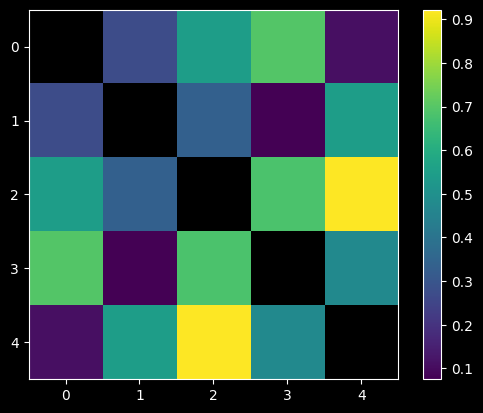

In [133]:

def visualize_weights(w: SymmetricWeights):
	full = []
	for i in range(w.units):
		f = []
		for j in range(w.units):
			if(i != j):
				f.append(w[i, j])
			else:
				f.append(np.NaN)
		full.append(f)
	plt.imshow(np.array(full))
	plt.colorbar()
visualize_weights(w)

Next I will define the actual Units. There will be visible units which I set my data to and there will be hidden units which learn in addition to the visible units. One of the underrated contributions of the paper!

The units can simply be defined as some adjacent units that we set.

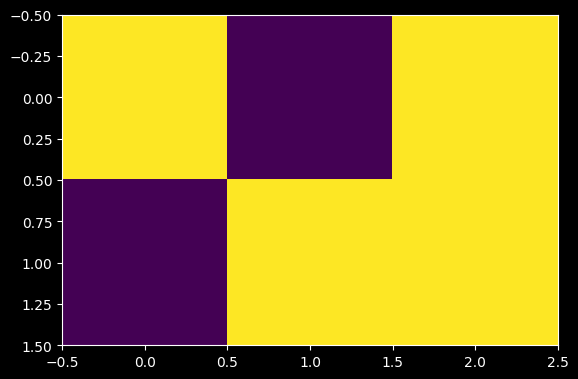

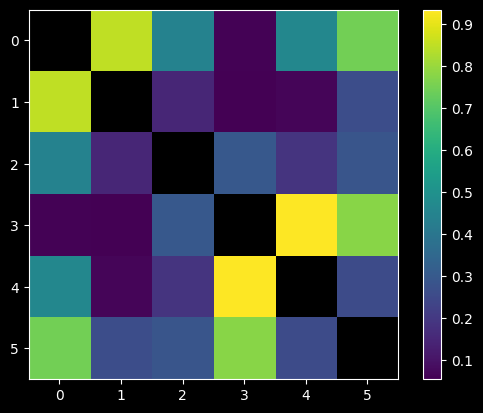

In [134]:
class Unit:
	def __init__(self):
		self.state = 1 if random.random() > 0.5 else 0

	def set_random_state(self):
		self.state = 1 if random.random() > 0.5 else 0

	def __repr__(self):
		return f"Unit(s={self.state})"

def visualize_units(units: list[Unit], shape):
	full = []
	for i in range(shape[0]):
		f = []
		for j in range(shape[1]):
			f.append(units[i*shape[1] + j].state)
		full.append(f)
	plt.imshow(np.array(full))

num_visible_units = 3
num_hidden_units = 3
total_units = num_visible_units + num_hidden_units 
visible_units = [Unit() for _ in range(num_visible_units)]
hidden_units = [Unit() for _ in range(num_hidden_units)]
units = [*visible_units, *hidden_units]

weights = SymmetricWeights(total_units)

visualize_units(units, (2,3))
plt.show()
visualize_weights(weights)